In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
var = 'amp'
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = rf'Data\Datasets\amz\{var}'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(rf'Data\Datasets\amz\{var}\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')
df_stat = pd.read_csv(rf'Data\Datasets\amz\{var}\stations_ts.csv', index_col=0)


In [5]:
ds_dict = {}
for i, dataset in enumerate(datasets):
    ds = xr.open_dataset(os.path.join(folder_metric, dataset + '.nc'))
    #create mask from regions
    mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
    ds['region'] = mask
    ds_dict[datasets_names[i]] = ds
    

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [18]:
df = pd.DataFrame()
for name in datasets_names:
    ds = ds_dict[name].groupby('region').mean()
    dff =  ds.to_dataframe().dropna().reset_index()
    dff['dataset'] = name
    df = df.append(dff)
df = df[['year',var, 'region', 'dataset','max','min']]
df['region'] = df['region'].replace({0:'West', 1:'North', 2:'South', 3:'East'})
df_stat = df_stat.merge(stations[['Code', 'Region']], on='Code')
df_stat = df_stat.rename(columns={'Region':'region', 'Date':'year'})
df_stat = df_stat.groupby(['region', 'year']).mean().reset_index().drop('Code', axis=1)
df_stat['dataset'] = 'Stations'
df = df.append(df_stat)

C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\1793007955.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\1793007955.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\1793007955.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\1793007955.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\1793007955.py:6: FutureWarning: The frame.append method is deprecat

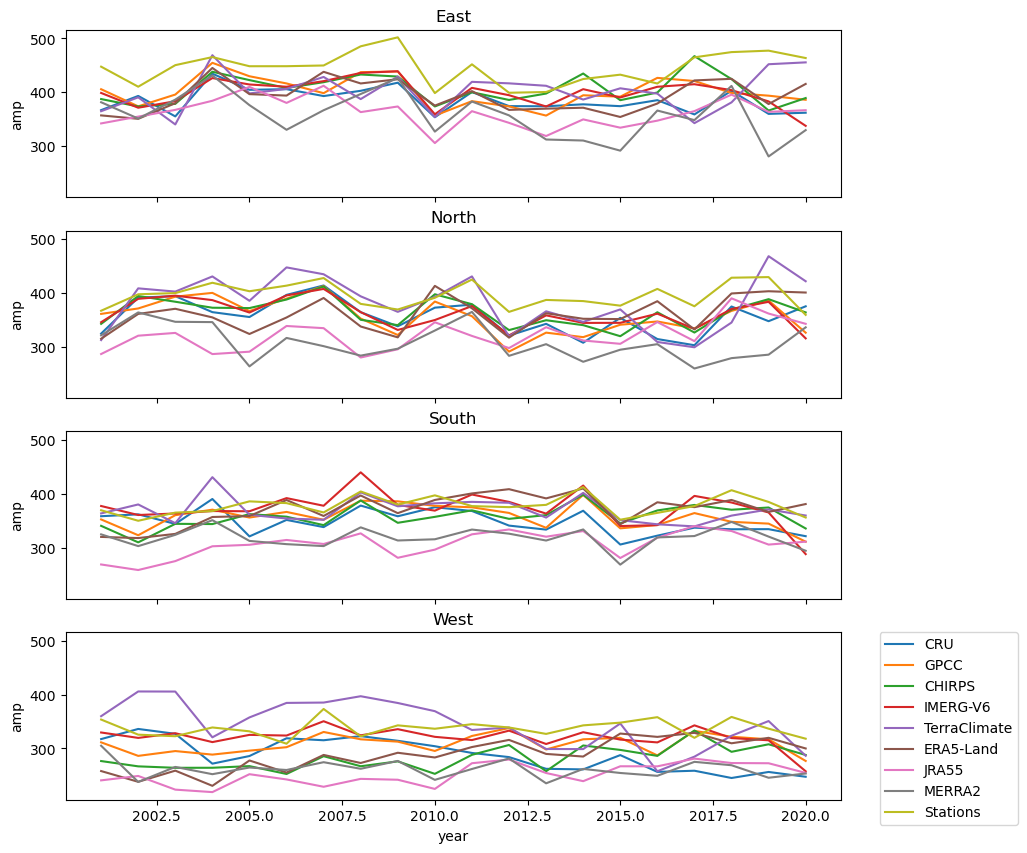

In [7]:
# a subplot for each region, with lineplot
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True, sharey=True)
for (region, d), ax in zip(df.groupby('region'), axes.flatten()):
    sns.lineplot(data=d, x='year', y=var, hue='dataset', ax=ax)
    ax.set_title(region)
#remove legend from all but the last
for ax in axes.flatten()[:-1]:
    ax.get_legend().remove()

#move legend to the outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [8]:
#for each dataset and each region, do the pearson r with stations
df_corr = pd.DataFrame()
for dataset in datasets_names:
    for region in ['West', 'North', 'South', 'East']:
        df_region = df[df['region']==region]
        df_region = df_region[df_region['dataset']==dataset]
        df_region = df_region[['year', var]]
        df_region = df_region.rename(columns={var:'pr_'+dataset})
        df_region = df_region.reset_index(drop=True)
        df_region = df_region.merge(df_stat[df_stat['region']==region][['year', var]], on='year')
        df_region = df_region.rename(columns={var:'pr_stations'})
        corr = df_region.corr().loc['pr_stations', 'pr_'+dataset]
        df_corr = df_corr.append(pd.DataFrame({'dataset':dataset, 'region':region, 'corr':corr}, index=[0]))

#pivot to plot a heatmap
df_corr = df_corr.pivot(index='dataset', columns='region', values='corr')
df_corr = df_corr.reindex(datasets_names)
df_corr = df_corr[['West', 'North', 'South', 'East']]
df_corr = df_corr.round(2)
df_corr = df_corr.T


C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\3808152756.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(pd.DataFrame({'dataset':dataset, 'region':region, 'corr':corr}, index=[0]))
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\3808152756.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(pd.DataFrame({'dataset':dataset, 'region':region, 'corr':corr}, index=[0]))
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\3808152756.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_corr = df_corr.append(pd.DataFrame({'dataset':dataset, 'region':region, 'corr':corr}, index=[0]))
C:\Users\luisg\AppData\Local\Temp\ipykernel_2548\3808152756.py:13: FutureWarning: The frame

<AxesSubplot: xlabel='dataset', ylabel='region'>

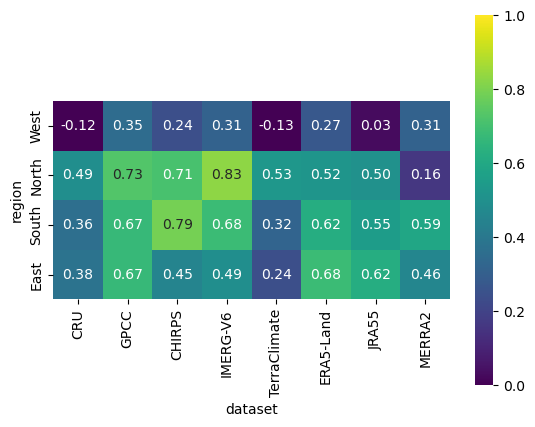

In [9]:
sns.heatmap(df_corr, annot=True, cmap='viridis', vmin=0, vmax=1, fmt='.2f', square=True)

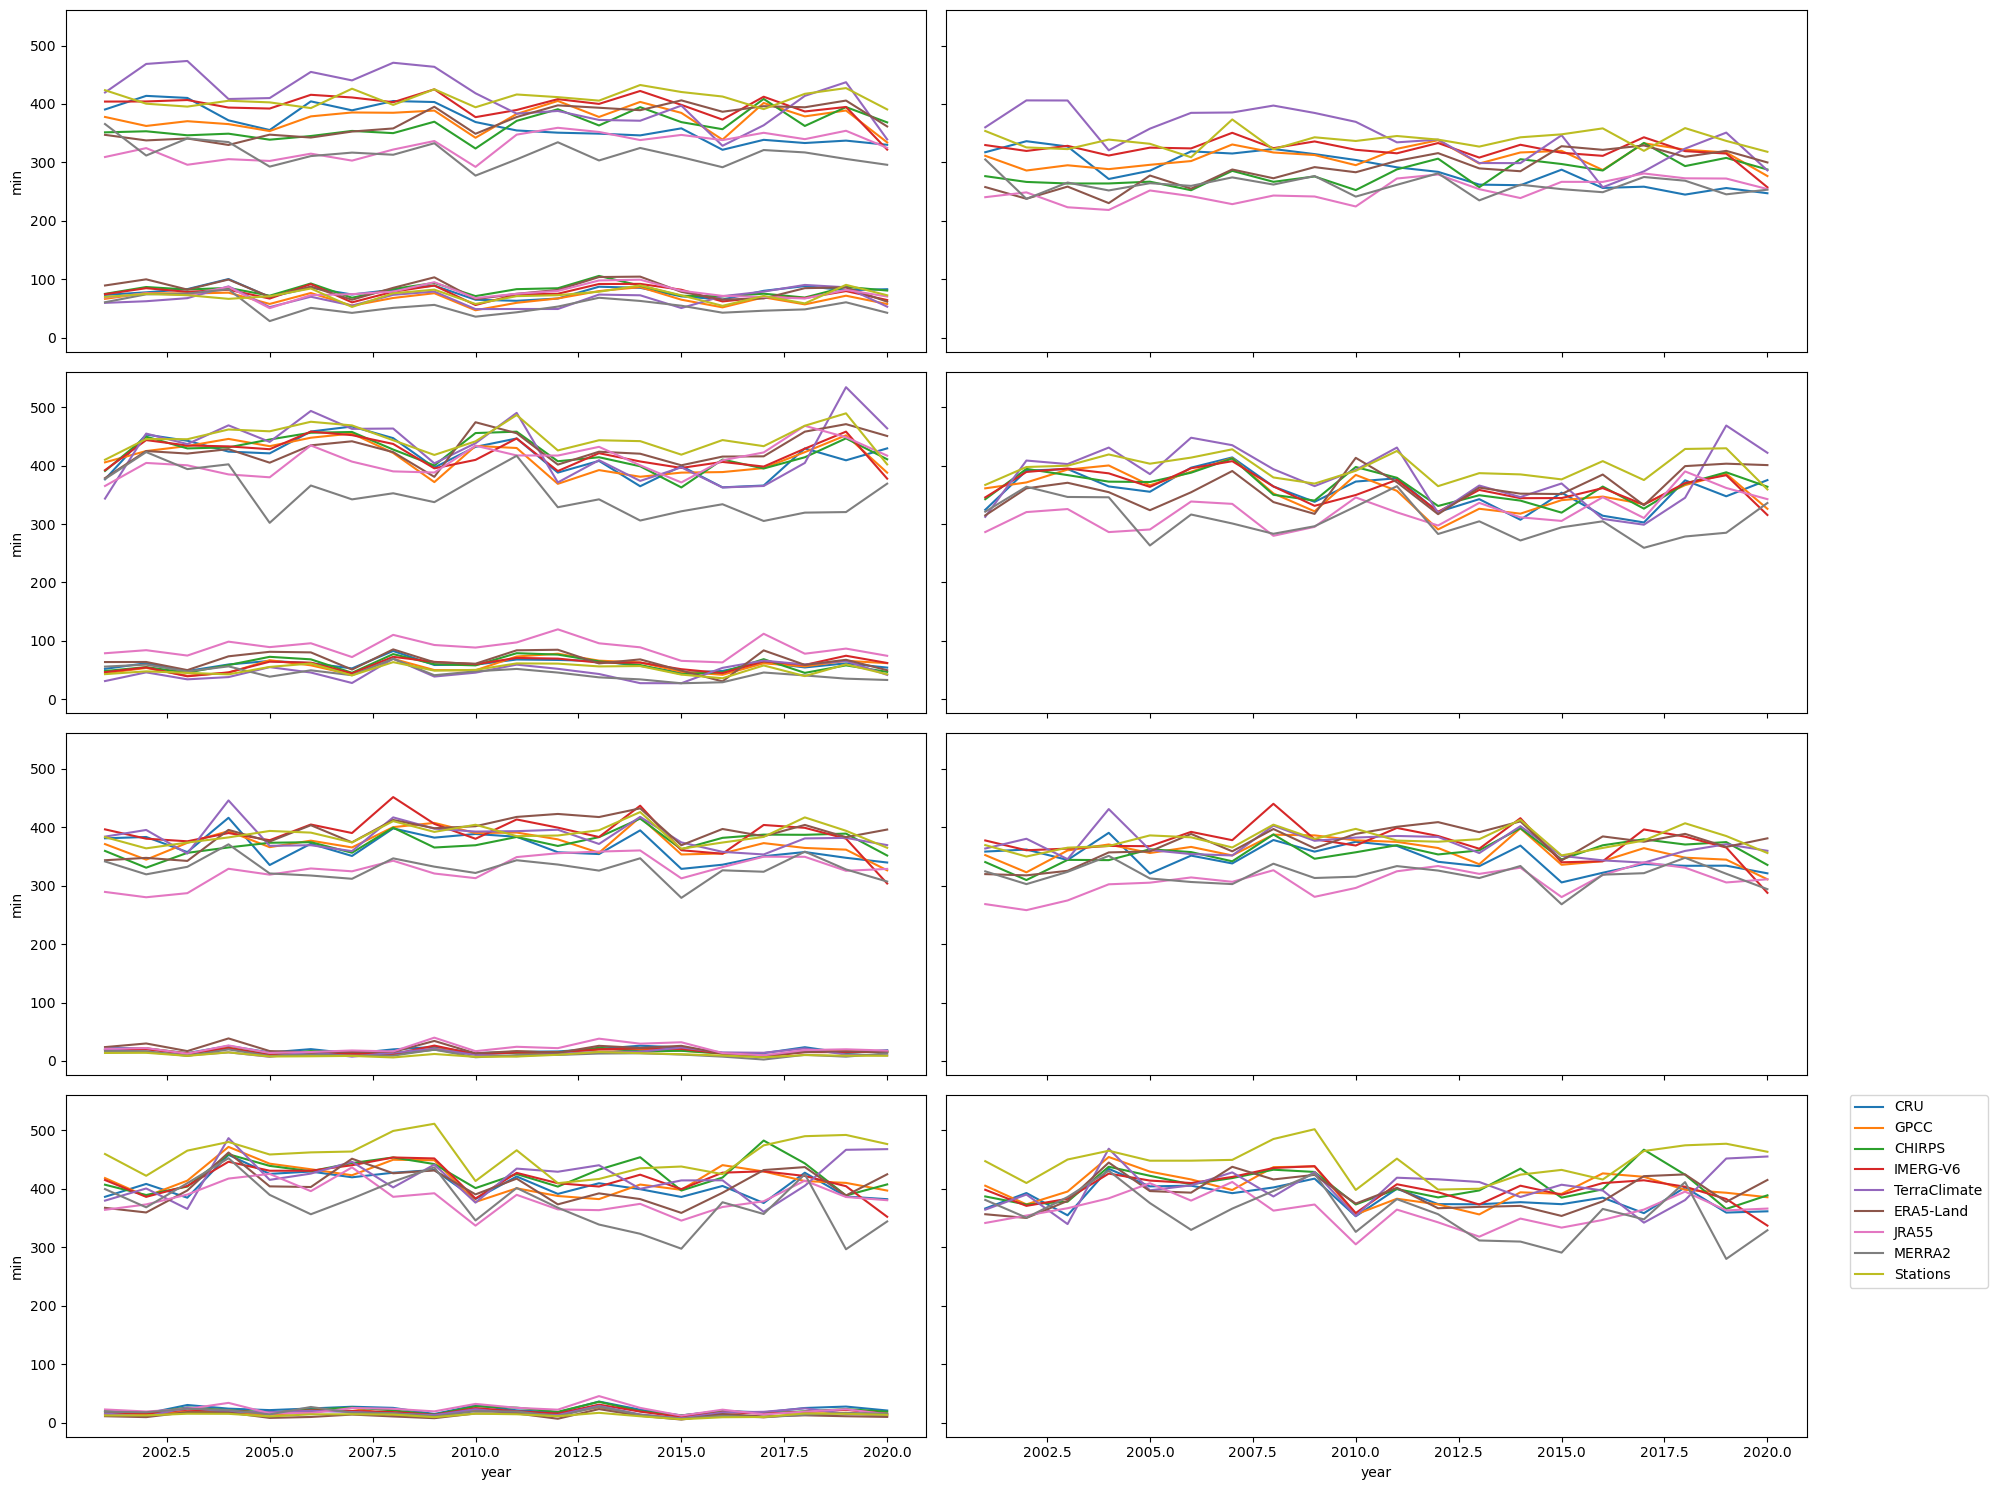

In [28]:
#plot lineplot for each of varibles for each region
fig, axes = plt.subplots(4, 2, figsize=(20, 15), sharex=True, sharey=True)
for i, region in enumerate(df.region.unique()):
    #first row min and max and second row amp
    df_region = df[df['region']==region]
    sns.lineplot(data=df_region, x='year', y='min', hue='dataset', ax=axes[i,0], legend=True)
    sns.lineplot(data=df_region, x='year', y='max', hue='dataset', ax=axes[i,0], legend=True)
    sns.lineplot(data=df_region, x='year', y=var, hue='dataset', ax=axes[i,1], legend=True)
    #remove legend from all but the last
for ax in axes.flatten()[:-1]:
    ax.get_legend().remove()

#move legend to the outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()